Loading MNIST data...
Creating binary classification task for digit 4...
Training logistic regression classifier...
Iteration 0, Training Error: 0.1011
Iteration 10, Training Error: 0.0974
Iteration 20, Training Error: 0.0974
Iteration 30, Training Error: 0.0974
Iteration 40, Training Error: 0.0974
Iteration 50, Training Error: 0.0974
Iteration 60, Training Error: 0.0974
Iteration 70, Training Error: 0.0974
Iteration 80, Training Error: 0.0974
Iteration 90, Training Error: 0.0974
Making predictions...

Test Accuracy (is 4 or not): 0.9018
Showing some misclassified examples...


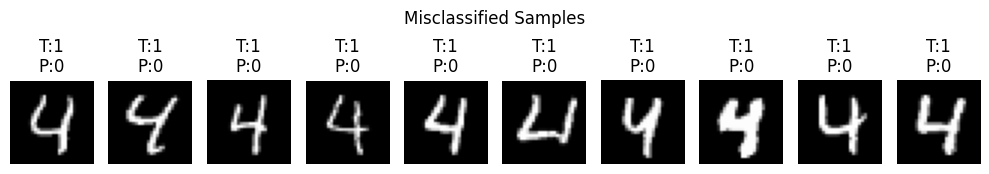


Autodiff Trace Table (sample features):
         Variable  Primal (v)  Forward Tangent (ẋ)  Reverse Adjoint (v̄ )
0       v0 (bias)    1.000000             0.000000              -0.001683
1         v1 (x1)    0.000000             1.000000              -0.003336
2         v2 (x2)    0.000000             0.000000               0.005299
3         v3 (w0)   -0.006733             0.000000               0.249997
4         v4 (w1)   -0.013343             0.000000               0.000000
5         v5 (w2)    0.021197             0.000000               0.000000
6       v6 (w0*1)   -0.006733             0.000000               0.249997
7      v7 (w1*x1)   -0.000000            -0.013343               0.249997
8      v8 (w2*x2)    0.000000             0.000000               0.249997
9   v9 (w0+w1*x1)   -0.006733            -0.013343               0.249997
10        v10 (z)   -0.006733            -0.013343               0.249997
11    v11 (y_hat)    0.498317            -0.003336               1.0000

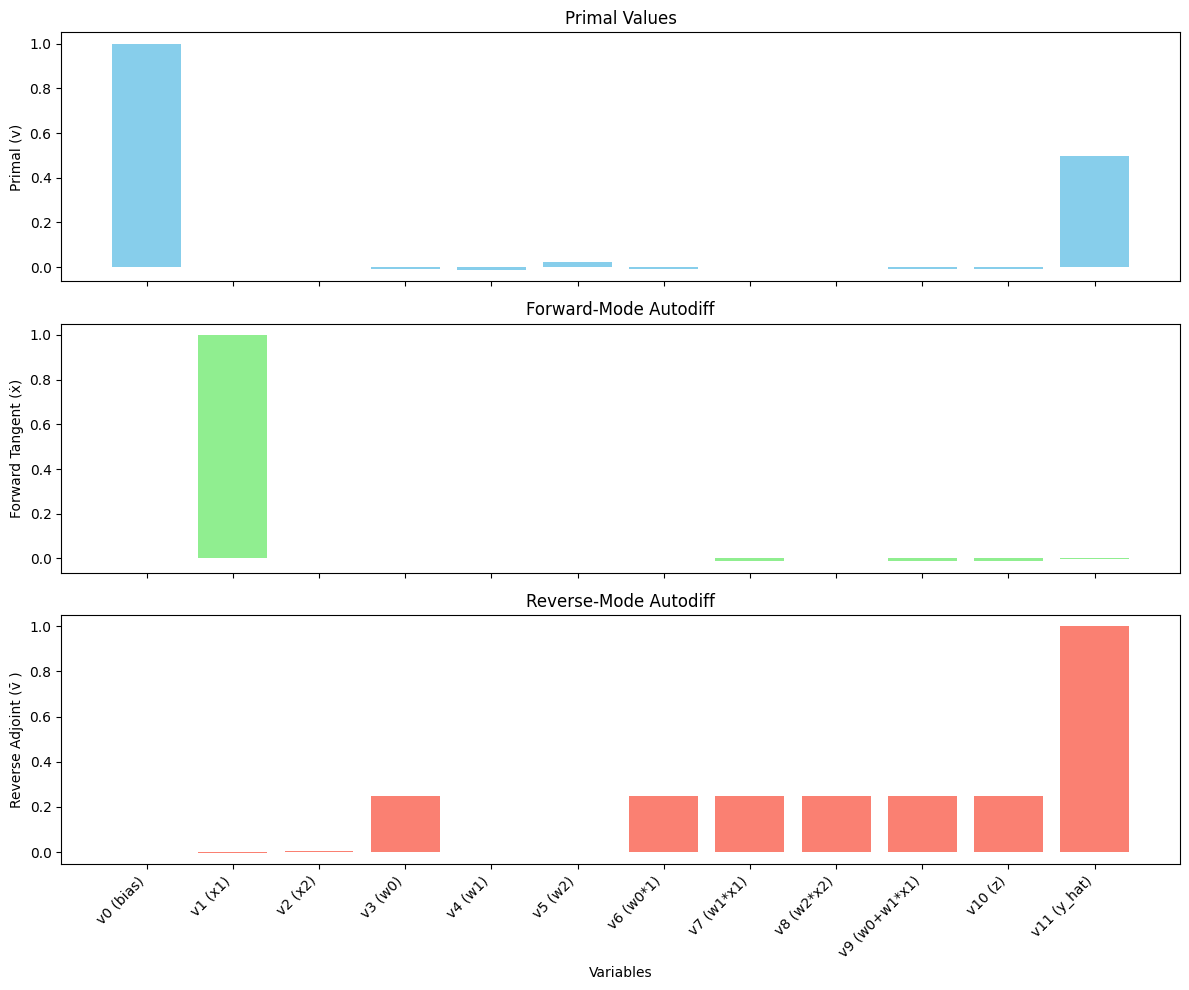

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import struct
import pandas as pd

# ========== Load Dataset ==========
def load_images(filename):
    with open(filename, 'rb') as f:
        _, num, rows, cols = struct.unpack(">IIII", f.read(16))
        data = np.frombuffer(f.read(), dtype=np.uint8).reshape((num, rows * cols))
    return data.astype(np.float32) / 255.0

def load_labels(filename):
    with open(filename, 'rb') as f:
        _, num = struct.unpack(">II", f.read(8))
        return np.frombuffer(f.read(), dtype=np.uint8)

# ========== 1. Sigmoid Function ==========
def sigmoid(z):
    # Implement sigmoid function with numerical stability
    return 1.0 / (1.0 + np.exp(-np.clip(z, -250, 250)))

def sigmoid_derivative(z):
    # Sigmoid derivative is sig(z) * (1 - sig(z))
    sig_z = sigmoid(z)
    return sig_z * (1 - sig_z)

# ====== 3. Forward and Reverse Autodiff Trace ========
def trace_autodiff_example(x1, x2, w):
    """
    Traces the autodiff computation for a simple logistic regression forward and backward pass
    for a single example with 2 features.
    
    This shows the computational graph for: y_hat = sigmoid(w0 + w1*x1 + w2*x2)
    """
    # Store all computations in variables for tracing
    v0 = 1.0  # bias
    v1 = x1   # first feature
    v2 = x2   # second feature
    v3 = w[0] # bias weight
    v4 = w[1] # first feature weight
    v5 = w[2] # second feature weight
    v6 = v3 * v0  # w0 * 1
    v7 = v4 * v1  # w1 * x1
    v8 = v5 * v2  # w2 * x2
    v9 = v6 + v7  # w0 + w1*x1
    v10 = v9 + v8 # w0 + w1*x1 + w2*x2
    v11 = sigmoid(v10)  # sigmoid(w0 + w1*x1 + w2*x2)
    
    # Forward tangent - initial seeds (partial derivatives with respect to inputs)
    # Let's seed w.r.t. x1 for this example (setting dx1/dx1 = 1, others to 0)
    ẋ0 = 0.0  # d(bias)/dx1
    ẋ1 = 1.0  # dx1/dx1
    ẋ2 = 0.0  # dx2/dx1
    ẋ3 = 0.0  # dw0/dx1
    ẋ4 = 0.0  # dw1/dx1
    ẋ5 = 0.0  # dw2/dx1
    
    # Forward mode - propagate tangents forward through the computation
    ẋ6 = ẋ3 * v0 + v3 * ẋ0  # d(w0 * 1)/dx1
    ẋ7 = ẋ4 * v1 + v4 * ẋ1  # d(w1 * x1)/dx1 = w1 since ẋ1 = 1
    ẋ8 = ẋ5 * v2 + v5 * ẋ2  # d(w2 * x2)/dx1 = 0
    ẋ9 = ẋ6 + ẋ7           # d(w0 + w1*x1)/dx1 = w1
    ẋ10 = ẋ9 + ẋ8          # d(w0 + w1*x1 + w2*x2)/dx1 = w1
    ẋ11 = sigmoid_derivative(v10) * ẋ10  # d(sigmoid(w0 + w1*x1 + w2*x2))/dx1
    
    # Reverse adjoint (backpropagation) - initialize with gradient of loss w.r.t output (here set to 1)
    v̄11 = 1.0  # For this example, we assume dL/dy_hat = 1
    v̄10 = v̄11 * sigmoid_derivative(v10)  # dL/dz = dL/dy_hat * dy_hat/dz
    v̄9 = v̄10  # dL/d(w0 + w1*x1) = dL/dz
    v̄8 = v̄10  # dL/d(w2*x2) = dL/dz
    v̄7 = v̄9   # dL/d(w1*x1) = dL/d(w0 + w1*x1)
    v̄6 = v̄9   # dL/d(w0*1) = dL/d(w0 + w1*x1)
    v̄5 = v̄8 * v2  # dL/dw2 = dL/d(w2*x2) * x2
    v̄4 = v̄7 * v1  # dL/dw1 = dL/d(w1*x1) * x1
    v̄3 = v̄6 * v0  # dL/dw0 = dL/d(w0*1) * 1
    v̄2 = v̄8 * v5  # dL/dx2 = dL/d(w2*x2) * w2
    v̄1 = v̄7 * v4  # dL/dx1 = dL/d(w1*x1) * w1
    v̄0 = v̄6 * v3  # dL/d(bias) = dL/d(w0*1) * w0
    
    # Create a dataframe to visualize the trace
    table = pd.DataFrame({
        'Variable': ['v0 (bias)', 'v1 (x1)', 'v2 (x2)', 'v3 (w0)', 'v4 (w1)', 'v5 (w2)', 
                    'v6 (w0*1)', 'v7 (w1*x1)', 'v8 (w2*x2)', 'v9 (w0+w1*x1)', 
                    'v10 (z)', 'v11 (y_hat)'],
        'Primal (v)': [v0, v1, v2, v3, v4, v5, v6, v7, v8, v9, v10, v11],
        'Forward Tangent (ẋ)': [ẋ0, ẋ1, ẋ2, ẋ3, ẋ4, ẋ5, ẋ6, ẋ7, ẋ8, ẋ9, ẋ10, ẋ11],
        'Reverse Adjoint (v̄ )': [v̄0, v̄1, v̄2, v̄3, v̄4, v̄5, v̄6, v̄7, v̄8, v̄9, v̄10, v̄11]
    })
    
    return table

# ========== 2. SGD: Algorithm 7.1 ==========
def your_sgd_logistic(X, y, eta=0.01, max_iters=100, batch_size=100):
    """
    Stochastic Gradient Descent for logistic regression.
    
    Parameters:
    -----------
    X : array-like, shape (n_samples, n_features)
        Training data
    y : array-like, shape (n_samples,)
        Target values (0 or 1)
    eta : float
        Learning rate
    max_iters : int
        Maximum number of iterations
    batch_size : int
        Size of mini-batches
        
    Returns:
    --------
    w : array, shape (n_features,)
        Weights after training
    trace : pandas DataFrame
        Autodiff trace for a sample calculation
    """
    n_samples, n_features = X.shape
    # Initialize weights to small random values
    w = np.random.randn(n_features) * 0.01
    
    trace = None  # Will store autodiff trace from first iteration
    
    for i in range(max_iters):
        # Sample a mini-batch
        indices = np.random.choice(n_samples, batch_size, replace=False)
        X_batch = X[indices]
        y_batch = y[indices]
        
        # Compute predictions
        z = X_batch @ w
        y_hat = sigmoid(z)
        
        # Compute error
        error = y_hat - y_batch
        
        # Compute gradient
        gradient = X_batch.T @ error / batch_size
        
        # Update weights
        w = w - eta * gradient
        
        # Save trace on first iteration using first two features of first sample
        if i == 0 and trace is None:
            trace = trace_autodiff_example(X_batch[0, 1], X_batch[0, 2], w)
            
        # Print progress
        if i % 10 == 0:
            train_error = np.mean((sigmoid(X @ w) > 0.5) != y)
            print(f"Iteration {i}, Training Error: {train_error:.4f}")
    
    return w, trace

# ==========Show Misclassified Samples ==========
def show_misclassified(X, y_true, y_pred, max_show=10):
    mis_idx = np.where(y_true != y_pred)[0][:max_show]
    if len(mis_idx) == 0:
        print("No misclassifications!")
        return
    
    plt.figure(figsize=(10, 2))
    for i, idx in enumerate(mis_idx):
        plt.subplot(1, len(mis_idx), i + 1)
        plt.imshow(X[idx, 1:].reshape(28, 28), cmap='gray')
        plt.axis('off')
        plt.title(f"T:{y_true[idx]}\nP:{y_pred[idx]}")
    plt.suptitle("Misclassified Samples")
    plt.tight_layout()
    plt.show()

# ========== Plot Trace Graph ==========
def plot_autodiff_traces(trace_df):
    variables = trace_df['Variable']
    primal = trace_df['Primal (v)'].astype(float)
    forward = pd.to_numeric(trace_df['Forward Tangent (ẋ)'], errors='coerce')
    reverse = pd.to_numeric(trace_df['Reverse Adjoint (v̄ )'], errors='coerce')
    
    fig, ax = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    
    ax[0].bar(variables, primal, color='skyblue')
    ax[0].set_ylabel("Primal (v)")
    ax[0].set_title("Primal Values")
    
    ax[1].bar(variables, forward, color='lightgreen')
    ax[1].set_ylabel("Forward Tangent (ẋ)")
    ax[1].set_title("Forward-Mode Autodiff")
    
    ax[2].bar(variables, reverse, color='salmon')
    ax[2].set_ylabel("Reverse Adjoint (v̄ )")
    ax[2].set_title("Reverse-Mode Autodiff")
    ax[2].set_xlabel("Variables")
    
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# ========== 3. Main ==========
def main():
    # === Load MNIST Data ===
    print("Loading MNIST data...")
    X_train = load_images("train-images.idx3-ubyte_____")
    y_train = load_labels("train-labels.idx1-ubyte_____")
    X_test = load_images("t10k-images.idx3-ubyte_____")
    y_test = load_labels("t10k-labels.idx1-ubyte_____")
    
    # === Binary Classification ===
    TARGET_DIGIT = 4  # Fill in (0 to 9) based on your student number
    print(f"Creating binary classification task for digit {TARGET_DIGIT}...")
    y_train_bin = np.where(y_train == TARGET_DIGIT, 1, 0)
    y_test_bin = np.where(y_test == TARGET_DIGIT, 1, 0)
    
    # === Add Bias ===
    X_train = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
    X_test = np.hstack([np.ones((X_test.shape[0], 1)), X_test])
    
    # === Train ===
    print("Training logistic regression classifier...")
    w, autodiff_trace = your_sgd_logistic(
        X_train, y_train_bin, eta=0.01, max_iters=100, batch_size=256
    )
    
    # === Predict ===
    print("Making predictions...")
    pred_probs = sigmoid(X_test @ w)
    preds = (pred_probs > 0.5).astype(int)
    
    # === Accuracy ===
    acc = np.mean(preds == y_test_bin)
    print(f"\nTest Accuracy (is {TARGET_DIGIT} or not): {acc:.4f}")
    
    # === Show Misclassifications ===
    print("Showing some misclassified examples...")
    show_misclassified(X_test, y_test_bin, preds)
    
    # === Visualize Autodiff Trace ===
    print("\nAutodiff Trace Table (sample features):")
    print(autodiff_trace)
    plot_autodiff_traces(autodiff_trace)

if __name__ == "__main__":
    main()